In [ ]:
!pip install ffmpeg-python

In [ ]:
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
#mounting a folder
from google.colab import drive
drive.mount('/content/drive')
# !ls /content/drive/My\ Drive/Rawdata

Mounted at /content/drive


In [ ]:
audio, sr = get_audio()

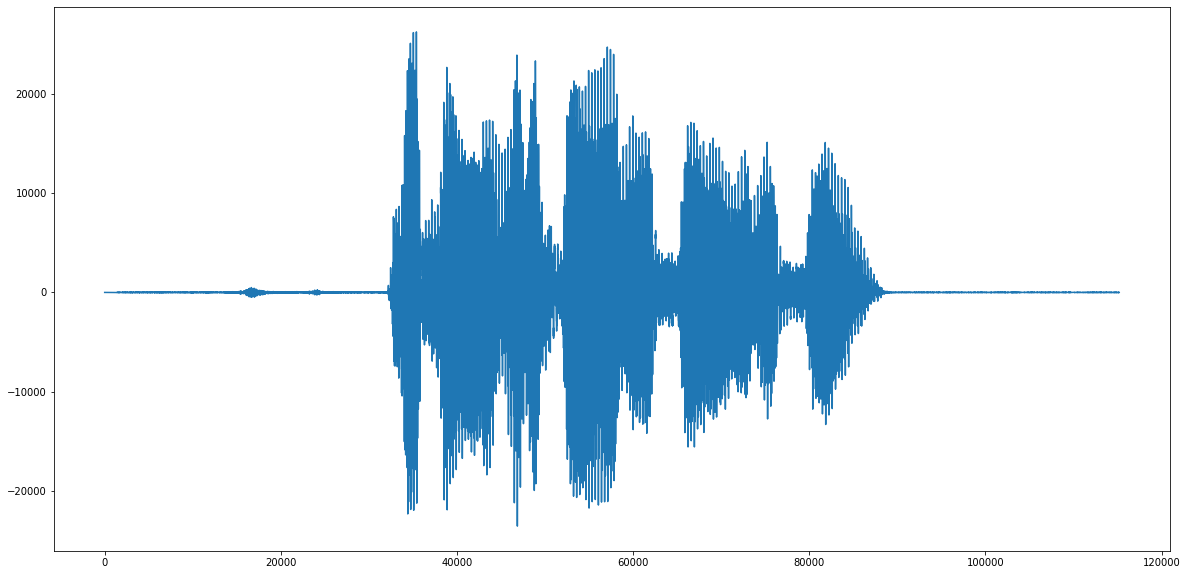

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(audio)
plt.show()

In [ ]:
# loading json and creating model
from keras.models import model_from_json
import keras
json_file = open('/content/drive/My Drive/saved_model/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("/content/drive/My Drive/saved_model/CNN.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
import wave
from scipy.io.wavfile import write as ww
output='/content/drive/My Drive/saved_model/output.wav'
ww(output,sr,audio)

In [ ]:
import librosa
data, sampling_rate = librosa.load(output)

Populating the interactive namespace from numpy and matplotlib


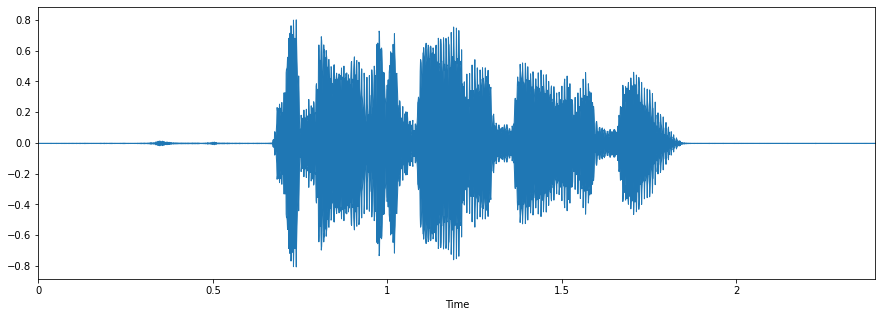

In [ ]:
% pylab inline
import os
import pandas as pd
import librosa.display
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [ ]:
livedf2=pd.DataFrame([])
for i in range(2,10):
  if len(livedf2.columns)<256:
    X, sample_rate = librosa.load(output, res_type='kaiser_fast',duration=2.5,sr=22050*i,offset=0.5)
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
    featurelive = mfccs
    livedf2 = featurelive
    livedf2= pd.DataFrame(data=livedf2)
    livedf2 = livedf2.stack().to_frame().T
  else:
    if len(livedf2.columns)>290:
      X, sample_rate = librosa.load(output, res_type='kaiser_fast',duration=2.5,sr=22050*(i-1.5),offset=0.5)
      sample_rate = np.array(sample_rate)
      mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
      featurelive = mfccs
      livedf2 = featurelive
      livedf2= pd.DataFrame(data=livedf2)
      livedf2 = livedf2.stack().to_frame().T
    break
print(livedf2)

         0          1          2    ...        284        285        286
           0          0          0  ...          0          0          0
0 -35.607777 -36.064449 -37.092667  ... -40.065121 -39.332485 -37.978348

[1 rows x 287 columns]


In [ ]:
twodim= np.expand_dims(livedf2, axis=2)
livepreds = loaded_model.predict(twodim, batch_size=32,verbose=1)

1/1 [==============================] - 10s 10s/step


In [ ]:
print(livepreds)
livepreds1=livepreds.argmax(axis=1)
liveabc = livepreds1.astype(int).flatten()

[[1.01811602e-03 2.77636369e-04 4.96576657e-04 2.92678043e-04
  2.18884656e-04 3.14888806e-04 9.44340791e-05 8.94333716e-05
  1.43703958e-02 1.53905945e-02 5.85351512e-02 8.03580880e-01
  9.15564597e-03 1.23904655e-02 7.71282390e-02 6.64595980e-03]]


In [ ]:
dir_list = os.listdir('/content/drive/My Drive/data/')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [ ]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
lb.classes_ = numpy.load('/content/drive/My Drive/saved_model/classes.npy',allow_pickle=True)

In [ ]:
livepredictions = (lb.inverse_transform((liveabc)))
print("Emotion detected: "+livepredictions[0])

Emotion detected: male_happy


In [ ]:
if(livepredictions[0]=='male_sad'):
  print("Suggested Playlist: "+ "https://open.spotify.com/playlist/7ABD15iASBIpPP5uJ5awvq")
elif(livepredictions[0]=='female_sad'):
  print("Suggested Playlist: "+ "https://open.spotify.com/playlist/37i9dQZF1DX7qK8ma5wgG1")
elif(livepredictions[0]=='male_happy'):
  print("Suggested Playlist: "+ "https://open.spotify.com/playlist/37i9dQZF1DXdPec7aLTmlC")
elif(livepredictions[0]=='female_happy'):
  print("Suggested Playlist: "+ "https://open.spotify.com/playlist/1h90L3LP8kAJ7KGjCV2Xfd")
elif(livepredictions[0]=='male_neutral'):
  print("Suggested Playlist: "+ "https://open.spotify.com/playlist/30TI3KL6mgjAHsE40w27cZ")
elif(livepredictions[0]=='female_neutral'):
  print("Suggested Playlist: "+ "https://open.spotify.com/playlist/2cThrQdD7NWH8kKJOFWKbt")
elif(livepredictions[0]=='male_scared'):
  print("Suggested Playlist: "+ "https://open.spotify.com/playlist/7rzS9iLiqjy65AsZd9qinf")
elif(livepredictions[0]=='female_scared'):
  print("Suggested Playlist: "+ "https://open.spotify.com/playlist/24cfndqnttuOPHEWfagCGG")
elif(livepredictions[0]=='male_angry'):
  print("Suggested Playlist: "+ "https://open.spotify.com/playlist/6ft4ijUITtTeVC0dUCDdvH")
elif(livepredictions[0]=='female_angry'):
  print("Suggested Playlist: "+ "https://open.spotify.com/playlist/5AiPzkrvxDguoJy9CR0OdF")
elif(livepredictions[0]=='male_calm'):
  print("Suggested Playlist: "+ "https://open.spotify.com/playlist/30TI3KL6mgjAHsE40w27cZ")
elif(livepredictions[0]=='female_calm'):
  print("Suggested Playlist: "+ "https://open.spotify.com/playlist/2cThrQdD7NWH8kKJOFWKbt")
elif(livepredictions[0]=='male_disgust'):
  print("Suggested Playlist: "+ "https://open.spotify.com/playlist/6ft4ijUITtTeVC0dUCDdvH")
elif(livepredictions[0]=='female_disgust'):
  print("Suggested Playlist: "+ "https://open.spotify.com/playlist/5AiPzkrvxDguoJy9CR0OdF")
elif(livepredictions[0]=='male_surprised'):
  print("Suggested Playlist: "+ "https://open.spotify.com/playlist/3H4UpSojtelWKZh41wjPFH")
elif(livepredictions[0]=='female_surprised'):
  print("Suggested Playlist: "+ "https://open.spotify.com/playlist/3H4UpSojtelWKZh41wjPFH")


Suggested Playlist: https://open.spotify.com/playlist/37i9dQZF1DXdPec7aLTmlC
